In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import itertools
import os
import matplotlib.pyplot as plt
os.getcwd()
%cd 'gdrive/My Drive'

/content/gdrive/My Drive


In [0]:
# Generative 

def conv2d(input_data,filter,ks,stride):
    
    cnv1 = tf.layers.conv2d(input_data,filters= filter, kernel_size= (ks,ks), strides= (stride,stride),padding="SAME" )
    cnv1 = tf.contrib.layers.instance_norm(cnv1)
    return tf.nn.leaky_relu(cnv1)


def conv2d_transpose(input_data,filter,kernel_size,stride):
    dcnv1 = tf.layers.conv2d_transpose(input_data,filters = filter,kernel_size=kernel_size,strides=  (stride,stride),padding='SAME')
    dcnv1 = tf.contrib.layers.instance_norm(dcnv1)
    return tf.nn.leaky_relu(dcnv1)

def resentBlock(input_data,filter,kernel_size,stride):
    
    firstOutput  = conv2d(input_data,filter,kernel_size,stride)
    secondOuput  = conv2d(firstOutput,filter,kernel_size,stride)
    
    return tf.nn.leaky_relu(secondOuput+input_data)


def generator(X,scope,reuse = False):
    #using tensorflow layer 
    #implementation of the architecture  Encoder -> Transformation -> decoder
    # Implementation fo U NET architecture 
    
    
    with tf.variable_scope(scope,reuse =reuse):
        #Convolution 2d
        cnv1 = conv2d(X,64,7,1)

        cnv2 = conv2d(cnv1,128,3,2)

        cnv3 = conv2d(cnv2,256,3,2)

        # resent Block

        resent1 = resentBlock(cnv3,256,3,1)
        resent2 = resentBlock(resent1,256,3,1)
        resent3 = resentBlock(resent2,256,3,1)
        resent4 = resentBlock(resent3,256,3,1)
        resent5 = resentBlock(resent4,256,3,1)
        resent6 = resentBlock(resent5,256,3,1)




        #     # deconvolutional layer

        deconv1 = conv2d_transpose(resent6,64,3,2)
        deconv2 =  conv2d_transpose(deconv1,128,3,2)
        #     #convolutional 2d

        conv3 = conv2d(deconv2,3,7,1)

        return conv3


        
def discriminator(X,scope,reuse=False):
    with tf.variable_scope(scope,reuse = reuse):

        cnv1 = conv2d(X,64,4,2)
        cnv2 = conv2d(cnv1,128,4,2)
        cnv3 = conv2d(cnv2,256,4,2)
        cnv4 = conv2d(cnv3,512,4,1)

        cnv5 = conv2d(cnv4,1,4,1)

        return cnv5
    
        
        

In [0]:
# Model architecture


input_A = tf.placeholder(tf.float32,shape=[None,256,256,3],name="input_A")
input_B = tf.placeholder(tf.float32,shape=[None,256,256,3],name="input_B")




In [5]:
# First Model
genB = generator(input_A,"GAB")
genA  = generator(input_B,"GBA")

cycleB = generator(genB,"GBA",True)
cycleA = generator(genA,"GAB",True)



DA =  discriminator(input_A,"DA")
DB1 =  discriminator(input_B,"DB")

DB =  discriminator(genB,"DB",True)
DA2 =  discriminator(genA,"DA",True)


W0731 12:24:20.198527 139901559707520 deprecation.py:323] From <ipython-input-3-83afdad75461>:4: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0731 12:24:20.211682 139901559707520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0731 12:24:21.257576 139901559707520 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for 

In [0]:
    #design a loss

# Discriptive loss 


D_A_loss =  (tf.reduce_mean(tf.square(DA - tf.ones_like(DA))) + tf.reduce_mean(tf.square(DB)))/2
D_B_loss =  (tf.reduce_mean(tf.square(DB1 - tf.ones_like(DB1))) + tf.reduce_mean(tf.square(DA2)))/2


# generative loss 

G_A_loss = tf.reduce_mean(tf.square(DB - tf.ones_like(DB)))
G_B_loss = tf.reduce_mean(tf.square(DA2 - tf.ones_like(DA2)))

# cyclic loss 

c_A_loss = tf.reduce_mean(tf.abs(cycleA - input_B)) + tf.reduce_mean(tf.abs(cycleB - input_A))

G_A_L = G_A_loss + 10*c_A_loss
G_B_L = G_B_loss + 10*c_A_loss




In [0]:

# need to collect the weights of the  variables


#generative weights
G_A_B =  tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"GAB")
G_B_A =  tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"GBA")

#discriminative weights
D_A =  tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"DA")
D_B =  tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"DB")



# Optimize the loss 

#optimize the discriminative loss
D_A_trainable = tf.train.AdamOptimizer(learning_rate=0.001).minimize(D_A_loss,var_list = D_A)
D_B_trainable = tf.train.AdamOptimizer(learning_rate=0.001).minimize(D_B_loss,var_list = D_B)

#Optimize the generaive loss 

G_A_trainable =  tf.train.AdamOptimizer(learning_rate=0.001).minimize(G_A_L,var_list = G_A_B)
G_B_trainable =  tf.train.AdamOptimizer(learning_rate=0.001).minimize(G_B_L,var_list = G_B_A)



In [0]:
import imageio
def preprocessing(image,name):
    batch_image  = []
    for img in image:
        if img.endswith("jpg"):
            img  =  imageio.imread("horse2zebra/"+str(name)+"/"+str(img))
            
            if img.shape == (256,256,3):
                batch_image.append(img)
        
    
    print("done")
    return np.array(batch_image)
          

In [0]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [0]:
def show_result(num_epoch,y_f,test_AB):
    
    if y_f:
        test_images = sess.run(genA, {input_B: test_AB})
    else:
        test_images = sess.run(genB, {input_A: test_AB})


    size_figure_grid = 4
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4,4))
    
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    
    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        a = np.reshape(test_images[k], (256, 256, 3))*255
        ax[i, j].imshow(a.astype(np.uint8))

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    plt.show()

In [11]:
input_A_train = os.listdir("horse2zebra/trainA/")
input_B_train = os.listdir("horse2zebra/trainB/")

input_A__ = preprocessing(input_A_train,"trainA")
input_B__ = preprocessing(input_B_train,"trainB")

input_B__ = input_B__[:len(input_A__)]

X_test  =  input_A__[:16]
Y_test  =  input_B__[:16]

batch_size = 6
for epoch in tqdm(range(20)):

    total_processing =  2
    total_size= len(input_A__)//batch_size
    

    for each in range(total_size):
        
        input_A_ =  input_A__[each*batch_size:(each+1)*batch_size]/255
        input_B_ =  input_B__[each*batch_size:(each +1)*batch_size]/255
        
        
        Y_fake,X_fake = sess.run([genB,genA],feed_dict={input_A:input_A_,input_B:input_B_})

        # generative loss 

        _,DAloss =  sess.run([D_A_trainable,D_A_loss],feed_dict={input_A:input_A_,input_B:input_B_})
        _,DBloss =  sess.run([D_B_trainable,D_B_loss],feed_dict={input_A:input_A_,input_B:input_B_})


        _,GAloss =  sess.run([G_A_trainable,G_A_L],feed_dict={input_A:input_A_,input_B:input_B_})
        _,GBloss =  sess.run([G_B_trainable,G_B_L],feed_dict={input_A:input_A_,input_B:input_B_})
        
        
    if epoch %5 == 0:
        
        
        print("Generated Loss {} , {} and Discriminative {}, {} ".format(GAloss,GBloss,DAloss,DBloss))
        with open("predicted/genALoss.txt",'a') as gAloss , open("predicted/genBLoss.txt",'a') as gBloss :
            
            
#             show_result((epoch + 1),True,X_test)
#             show_result((epoch + 1),False,Y_test)
            
            gAloss.write(str(GAloss))
            gAloss.write("\n")
            gBloss.write(str(GBloss))
            gBloss.write("\n")

done


  0%|          | 0/20 [00:00<?, ?it/s]

done


  5%|▌         | 1/20 [14:08<4:28:44, 848.65s/it]

Generated Loss 5.39708948135376 , 5.346433162689209 and Discriminative 0.42669016122817993, 0.4267255663871765 


 30%|███       | 6/20 [1:23:54<3:15:48, 839.15s/it]

Generated Loss 3.2898097038269043 , 3.245600700378418 and Discriminative 0.4021197557449341, 0.4084073305130005 


 55%|█████▌    | 11/20 [2:33:41<2:05:37, 837.50s/it]

Generated Loss 3.160537004470825 , 3.135629892349243 and Discriminative 0.49821609258651733, 0.49840638041496277 


 80%|████████  | 16/20 [3:43:24<55:47, 836.76s/it]  

Generated Loss 2.9093387126922607 , 2.894030809402466 and Discriminative 0.4999975264072418, 0.4999975860118866 


100%|██████████| 20/20 [4:39:11<00:00, 836.68s/it]


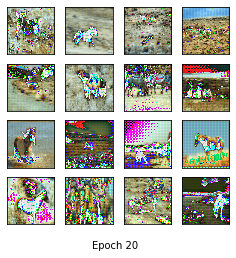

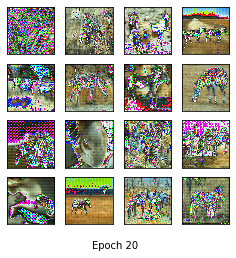

In [49]:
data  =  X_test.astype(np.float)/255
data  =  data.reshape(-1,256,256,3)
show_result((20),True,data)


data  =  Y_test.astype(np.float)/255
data  =  data.reshape(-1,256,256,3)
show_result((20),True,data)



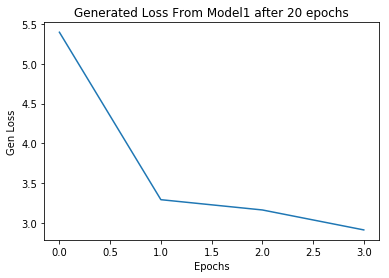

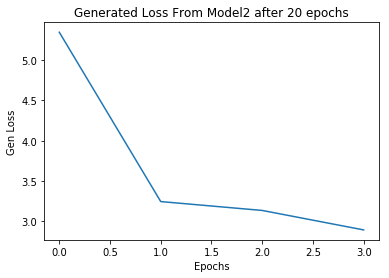

In [54]:
genAloss = []
genBloss = []


with open("predicted/genALoss.txt") as modelA , open("predicted/genBLoss.txt") as modelB:
  
  for line in modelA:
    genAloss.append(float(line))
   
  for line in modelB:
    genBloss.append(float(line))
    
   
 


plt.plot(genAloss)
plt.title("Generated Loss From Model1 after 20 epochs")
plt.xlabel("Epochs")
plt.ylabel("Gen Loss")
plt.show()
    
    
plt.plot(genBloss)
plt.title("Generated Loss From Model2 after 20 epochs")
plt.xlabel("Epochs") 
plt.ylabel("Gen Loss")
plt.show()
    
    
    
  